# Лабораторная работа № 4
## Работу выполнил - Сучков Василий, группа - ББМО-01-22
### Защита от атак FGSM методом "Дестиляции"

Выполним импорт необходимых библиотек


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Загрузим датасет MNIST и предобработаем его

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

Устанавливаем выполнения проекта на GPU (CUDA)

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создаем Нейронную сеть

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Инициализируем модель

In [5]:
model = Net().to(device)

Создаем оптимизатор, функцию потерь и трейнер сети.

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Создаем обучающую функцию

In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss


Обучаем модель

In [8]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.2749527140926495 Val_Loss: 0.12202424498978112
Epoch: 2 Loss: 0.1068075448682209 Val_Loss: 0.09646850880548638
Epoch: 3 Loss: 0.08965385304768432 Val_Loss: 0.09651554442809884
Epoch: 4 Loss: 0.08134287437569994 Val_Loss: 0.0859249773323113
Epoch: 5 Loss: 0.08018664438748836 Val_Loss: 0.08944789385420009
Epoch: 6 Loss: 0.07827179523214645 Val_Loss: 0.08311798576453508
Epoch: 7 Loss: 0.07756542472403866 Val_Loss: 0.09091331673957402
Epoch: 8 Loss: 0.08007124719977664 Val_Loss: 0.09338557863650708
Epoch: 9 Loss: 0.08113128909458864 Val_Loss: 0.11263560052257815
Epoch: 10 Loss: 0.07922112407009416 Val_Loss: 0.08729609617829408


Построим графики потерь при обучении и валидации в
зависимости от эпохи



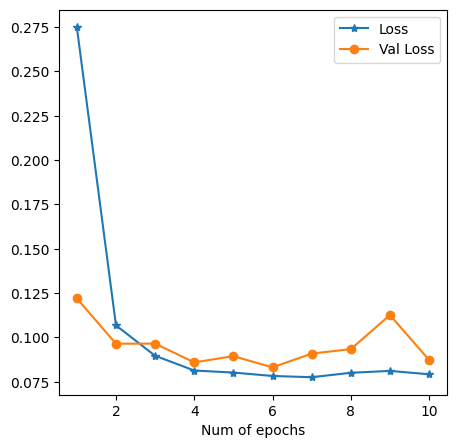

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создадим функции атак FGSM, I-FGSM, MI-FGSM

In [4]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Создадим функцию проверки

In [11]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Построим графики успешности атак(Accuracy/эпсилон)
и примеры выполненных атак в зависимости от степени
возмущения epsilon:

Epsilon: 0	Test Accuracy = 9648 / 10000 = 0.9648
Epsilon: 0.007	Test Accuracy = 9627 / 10000 = 0.9627
Epsilon: 0.01	Test Accuracy = 9590 / 10000 = 0.959
Epsilon: 0.02	Test Accuracy = 9523 / 10000 = 0.9523
Epsilon: 0.03	Test Accuracy = 9432 / 10000 = 0.9432
Epsilon: 0.05	Test Accuracy = 9060 / 10000 = 0.906
Epsilon: 0.1	Test Accuracy = 6060 / 10000 = 0.606
Epsilon: 0.2	Test Accuracy = 1929 / 10000 = 0.1929
Epsilon: 0.3	Test Accuracy = 1438 / 10000 = 0.1438


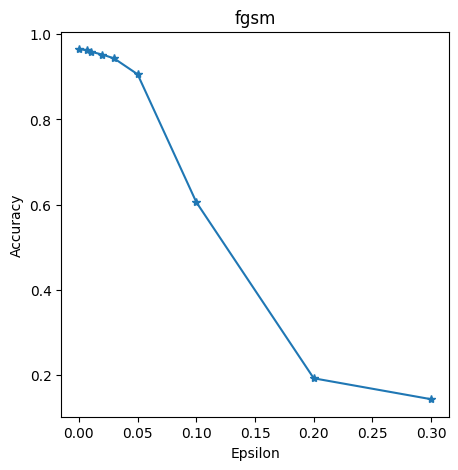

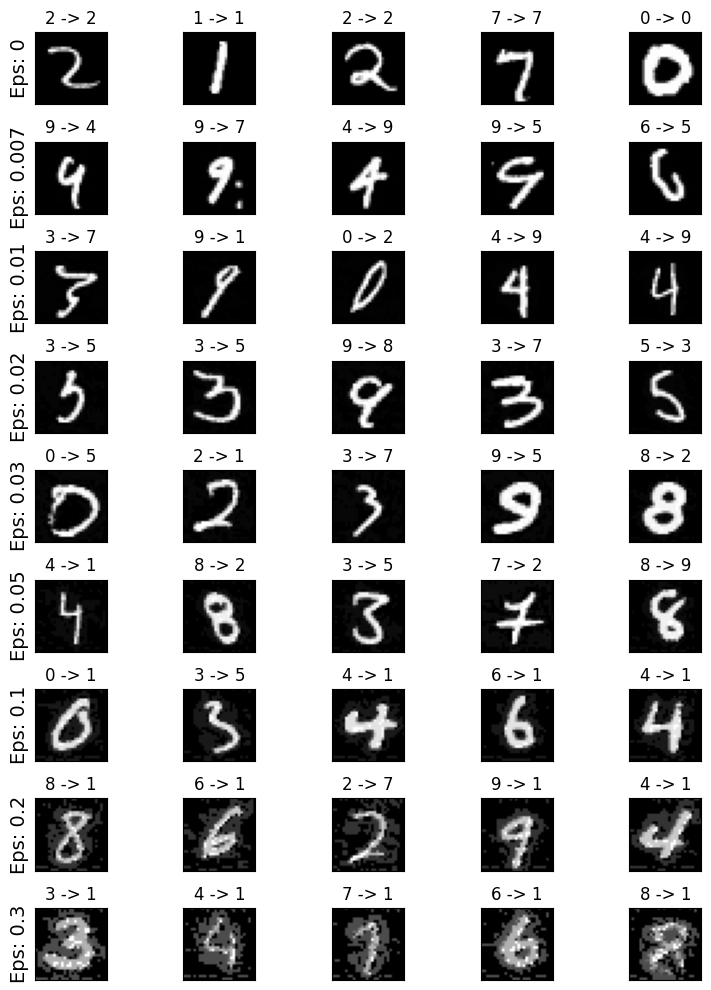

Epsilon: 0	Test Accuracy = 9630 / 10000 = 0.963
Epsilon: 0.007	Test Accuracy = 9596 / 10000 = 0.9596
Epsilon: 0.01	Test Accuracy = 9614 / 10000 = 0.9614
Epsilon: 0.02	Test Accuracy = 9535 / 10000 = 0.9535
Epsilon: 0.03	Test Accuracy = 9451 / 10000 = 0.9451
Epsilon: 0.05	Test Accuracy = 9162 / 10000 = 0.9162
Epsilon: 0.1	Test Accuracy = 6874 / 10000 = 0.6874
Epsilon: 0.2	Test Accuracy = 2243 / 10000 = 0.2243
Epsilon: 0.3	Test Accuracy = 1490 / 10000 = 0.149


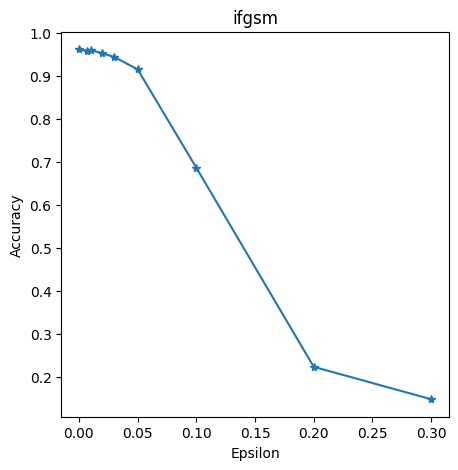

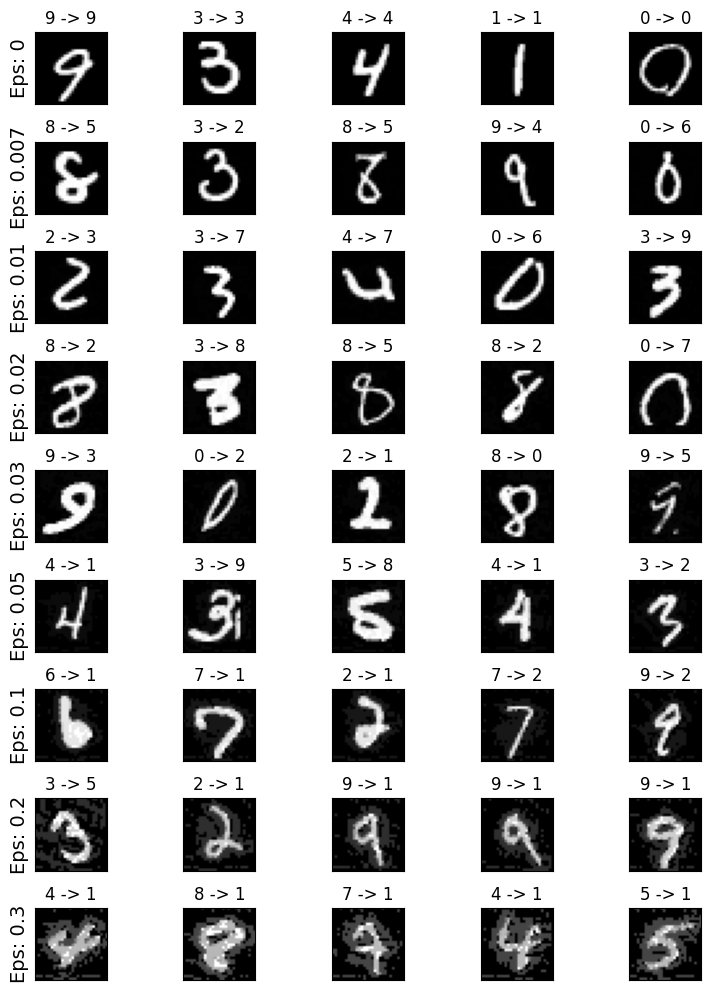

Epsilon: 0	Test Accuracy = 9659 / 10000 = 0.9659
Epsilon: 0.007	Test Accuracy = 9630 / 10000 = 0.963
Epsilon: 0.01	Test Accuracy = 9593 / 10000 = 0.9593
Epsilon: 0.02	Test Accuracy = 9544 / 10000 = 0.9544
Epsilon: 0.03	Test Accuracy = 9472 / 10000 = 0.9472
Epsilon: 0.05	Test Accuracy = 9195 / 10000 = 0.9195
Epsilon: 0.1	Test Accuracy = 6831 / 10000 = 0.6831
Epsilon: 0.2	Test Accuracy = 2251 / 10000 = 0.2251
Epsilon: 0.3	Test Accuracy = 1546 / 10000 = 0.1546


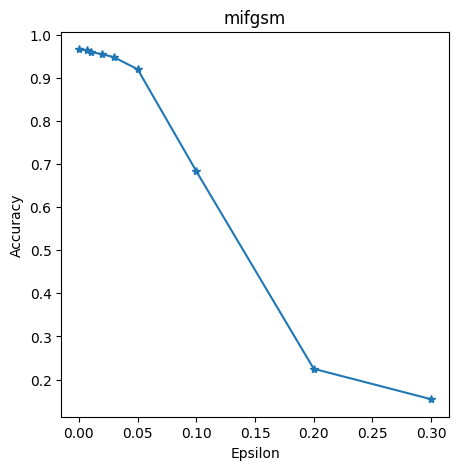

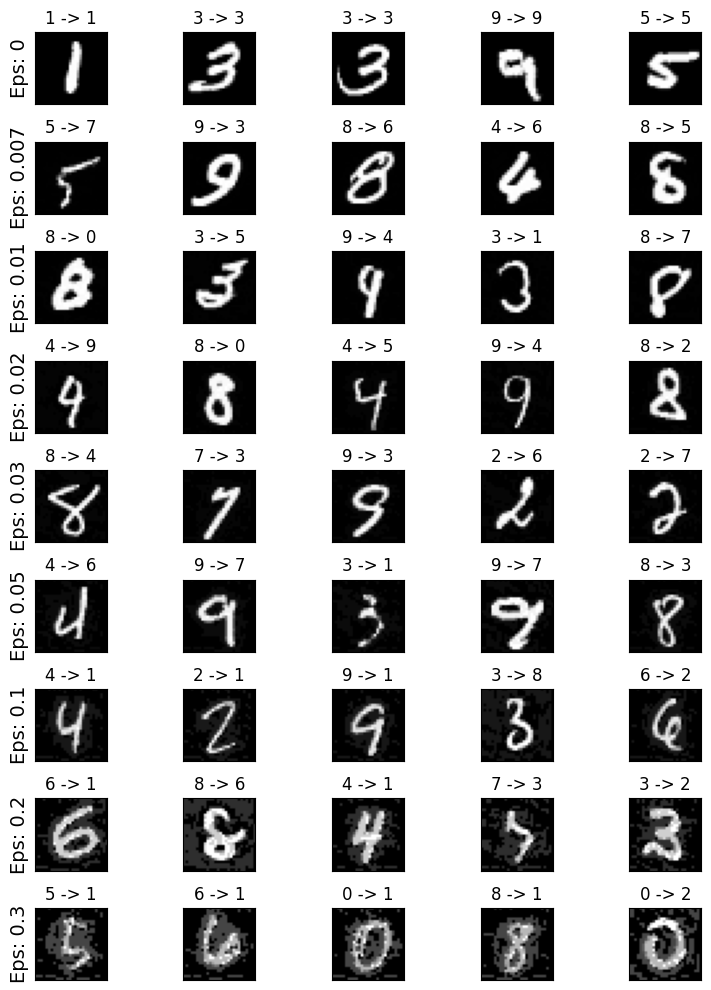

In [12]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

# Реализация защиты от атак fgsm, ifgsm, mifgsm
Создадим 2 класса НС

In [5]:

class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределим функцию обучения и тестирования

In [6]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

Создадим функцию защиты методом дистилляции

In [7]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Получим результаты оценки защищенных сетей


Fitting the model...
Epoch: 1 Loss: 0.5914319338309205 Val_Loss: 0.4208010597654996
Epoch: 2 Loss: 0.35254732449539666 Val_Loss: 0.27947702636577354
Epoch: 3 Loss: 0.2352967838233575 Val_Loss: 0.18347587407191182
Epoch: 4 Loss: 0.17095924544602928 Val_Loss: 0.1533666030183842
Epoch: 5 Loss: 0.1373992687668315 Val_Loss: 0.11991949459316954
Epoch: 6 Loss: 0.11993696157290169 Val_Loss: 0.11527672231801168
Epoch: 7 Loss: 0.1081797510758487 Val_Loss: 0.10517813642392464
Epoch: 8 Loss: 0.10190559335865862 Val_Loss: 0.11251097665910705
Epoch: 9 Loss: 0.09540538158972471 Val_Loss: 0.09955265630157147
Epoch: 10 Loss: 0.09091524543317253 Val_Loss: 0.10096578461677494


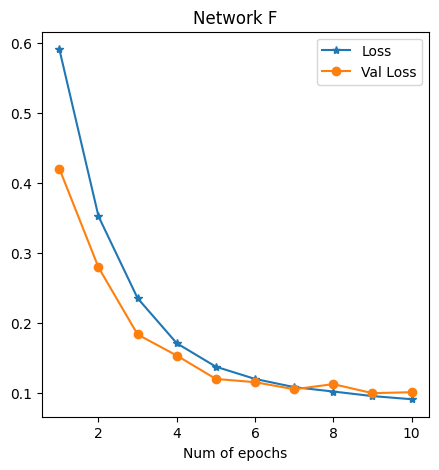

Fitting the model...
Epoch: 1 Loss: 0.6893553628866745 Val_Loss: 0.5162781449171815
Epoch: 2 Loss: 0.4888300740692653 Val_Loss: 0.471053630128566
Epoch: 3 Loss: 0.43946779596786606 Val_Loss: 0.4197352662907043
Epoch: 4 Loss: 0.4013721675285165 Val_Loss: 0.38602452662477754
Epoch: 5 Loss: 0.3542975119325473 Val_Loss: 0.3180178984209406
Epoch: 6 Loss: 0.29912000817698653 Val_Loss: 0.2803191360460575
Epoch: 7 Loss: 0.26179602935960977 Val_Loss: 0.24927071500932174
Epoch: 8 Loss: 0.22785844836885907 Val_Loss: 0.2075411776587448
Epoch: 9 Loss: 0.2047142563650512 Val_Loss: 0.19308143560217997
Epoch: 10 Loss: 0.18340700068801394 Val_Loss: 0.17493744941662315


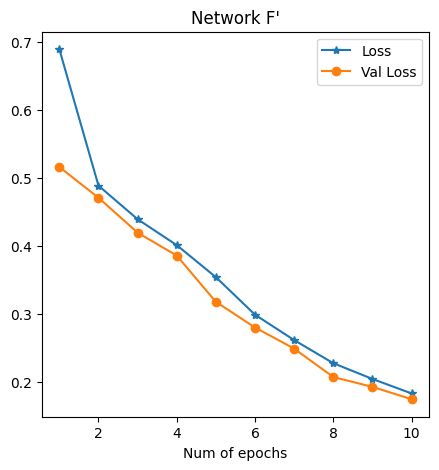

Epsilon: 0	Test Accuracy = 9295 / 10000 = 0.9295
Epsilon: 0.007	Test Accuracy = 9241 / 10000 = 0.9241
Epsilon: 0.01	Test Accuracy = 9278 / 10000 = 0.9278
Epsilon: 0.02	Test Accuracy = 9225 / 10000 = 0.9225
Epsilon: 0.03	Test Accuracy = 9232 / 10000 = 0.9232
Epsilon: 0.05	Test Accuracy = 9237 / 10000 = 0.9237
Epsilon: 0.1	Test Accuracy = 9170 / 10000 = 0.917
Epsilon: 0.2	Test Accuracy = 9125 / 10000 = 0.9125
Epsilon: 0.3	Test Accuracy = 9105 / 10000 = 0.9105


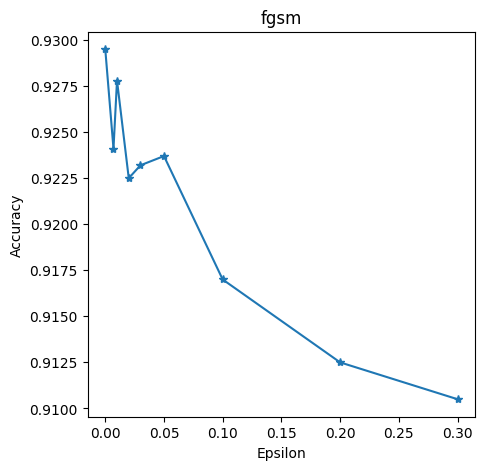

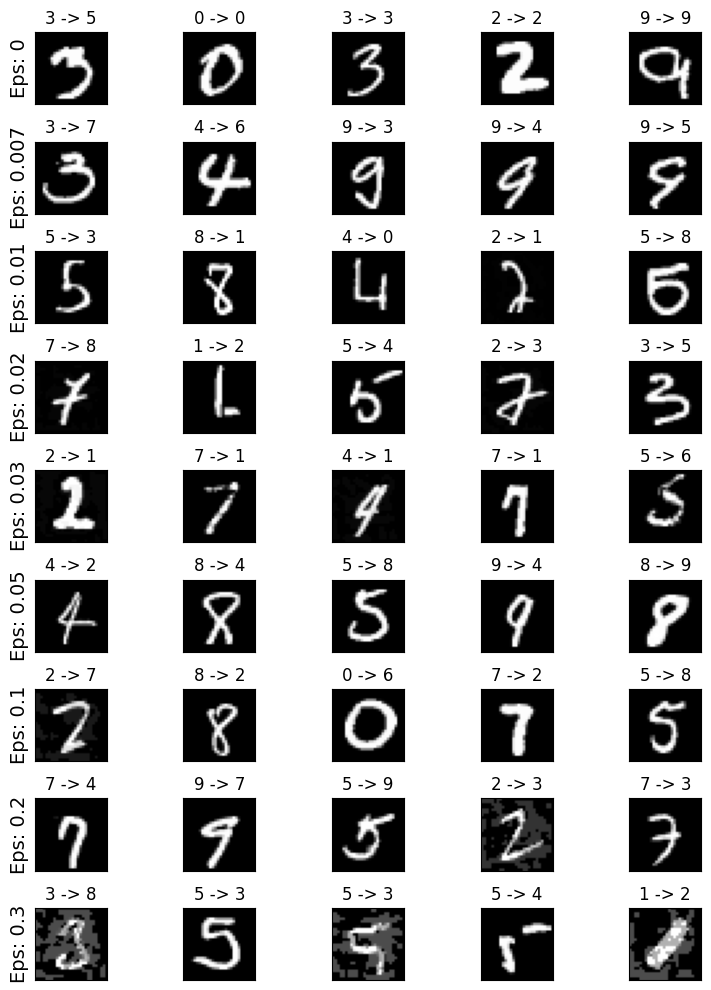

Epsilon: 0	Test Accuracy = 9267 / 10000 = 0.9267
Epsilon: 0.007	Test Accuracy = 9273 / 10000 = 0.9273
Epsilon: 0.01	Test Accuracy = 9273 / 10000 = 0.9273
Epsilon: 0.02	Test Accuracy = 9254 / 10000 = 0.9254
Epsilon: 0.03	Test Accuracy = 9202 / 10000 = 0.9202
Epsilon: 0.05	Test Accuracy = 9230 / 10000 = 0.923
Epsilon: 0.1	Test Accuracy = 9193 / 10000 = 0.9193
Epsilon: 0.2	Test Accuracy = 9152 / 10000 = 0.9152
Epsilon: 0.3	Test Accuracy = 9085 / 10000 = 0.9085


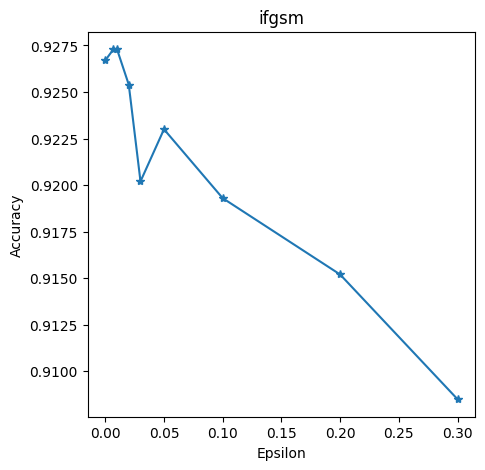

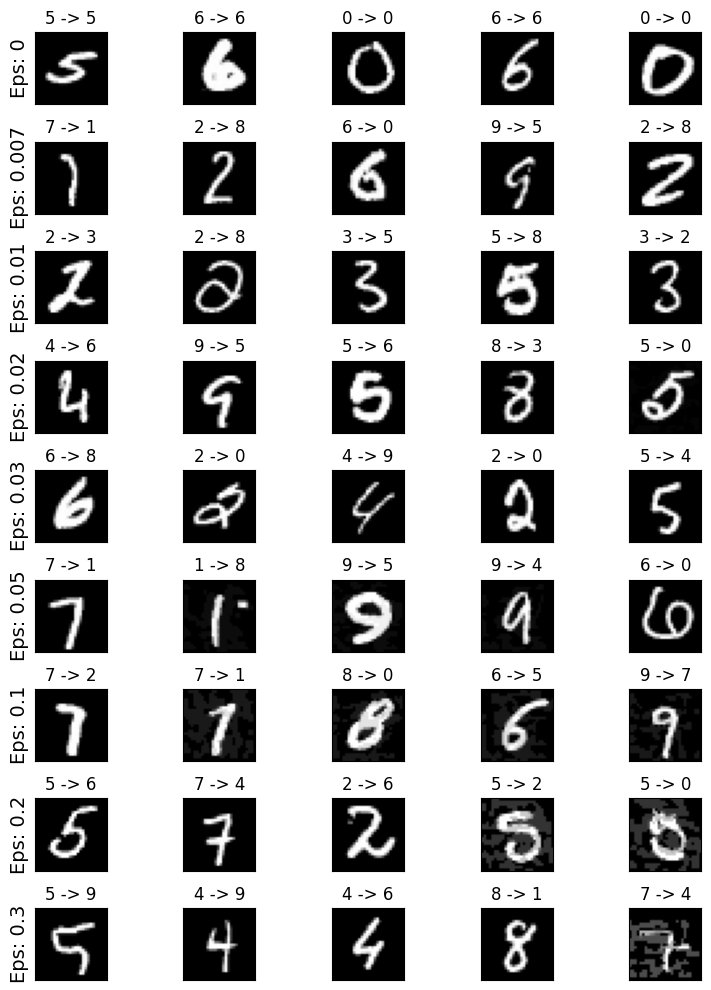

Epsilon: 0	Test Accuracy = 9272 / 10000 = 0.9272
Epsilon: 0.007	Test Accuracy = 9235 / 10000 = 0.9235
Epsilon: 0.01	Test Accuracy = 9282 / 10000 = 0.9282
Epsilon: 0.02	Test Accuracy = 9230 / 10000 = 0.923
Epsilon: 0.03	Test Accuracy = 9250 / 10000 = 0.925
Epsilon: 0.05	Test Accuracy = 9239 / 10000 = 0.9239
Epsilon: 0.1	Test Accuracy = 9192 / 10000 = 0.9192
Epsilon: 0.2	Test Accuracy = 9128 / 10000 = 0.9128
Epsilon: 0.3	Test Accuracy = 9066 / 10000 = 0.9066


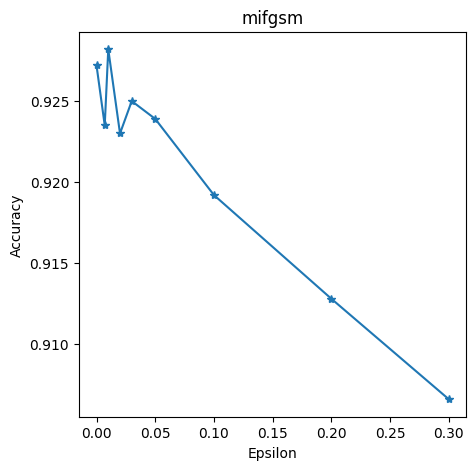

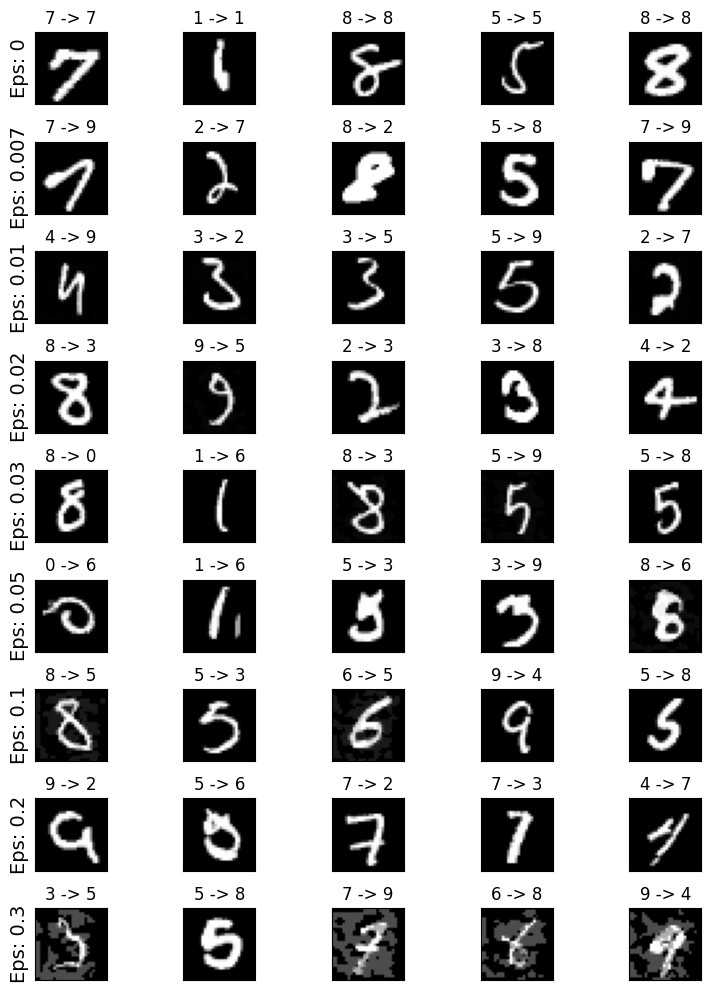

In [8]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)

# Как это работает? Нам не спроста нужны 2 модели.
Модель NetF - учитель, она нужна, для того, чтобы обучиться на наборе данных, после чего, внести небольшой шум в данные labels (soft labels) : `softlabel  = F.log_softmax(modelF(input),dim=1)`

NetF1 - модель ученик, будет учиться угадывать метки, которые предсказал "учитель", таким образом модель учится на основе обучения "учителя" (который заведомо не подверженого атаке), что повышает устойчивость к атакам, нацеленным на внесение шума.

### Также, есть реализация дестиляции, в которой изменению подвергаются не только метки, но и входные данные для обучения NetF1 (вносится небольшой шум в input data), это еще сильнее повышает стойкость модели.

# Итог по увеличению стойкости модели:
* атака fgsm снизила точность не защищенных данных до - 14%, защищенных - до - 91%
* атака ifgsm снизила точность не защищенных данных до - 15%, защищенных - до - 91%
* атака mifgsm снизила точность не защищенных данных до - 15%, защищенных - до - 91%

Важно отметить, что модель, которая обучалась на метках учителя имеет большее значение потерь после обучения, но это невилируется ее стойкостью к атакам FGSM.